# TGS Salt Identification Challenge

**To create this PyTorch implementation, I have used [this](https://www.kaggle.com/blaxkdolphin/unet-pytorch) link as reference.**

In [ ]:
!nvidia-smi

Sun Feb 14 06:40:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# importing libraries
import os
import time
import math
import glob
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

# importing PyTorch stuffs
import torch
# nn contains all the basic building blocks for PyTorch
import torch.nn as nn
# nn.functional is equivalent to Keras's functional API
import torch.nn.functional as F
# DataLoader - represent a python iterable over the dataset, which support single and multi-process dataloading and memory handling
# Dataset - argument to the DataLoader, which indicates a dataset object to load data from.
from torch.utils.data import Dataset, DataLoader
# The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision
import torchvision
# common image transformations(augmentations) can be achieved by using transforms
import torchvision.transforms as T

In [ ]:
# A torch.device is an object representing the device on which a torch.Tensor is or will be allocated
# cuda is a parallel computing plateform, comes with the GPU's
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# copying zip file to google colab

!cp -r '/content/drive/MyDrive/Kaggle_Salt_Identification/competition_data.zip' '/content/'

In [ ]:
# unzipping the zipped files
! unzip -q /content/competition_data.zip

In [ ]:
# setting image path
image_path = "/content/competition_data/train/images"
# setting mask path
mask_path = "/content/competition_data/train/masks"

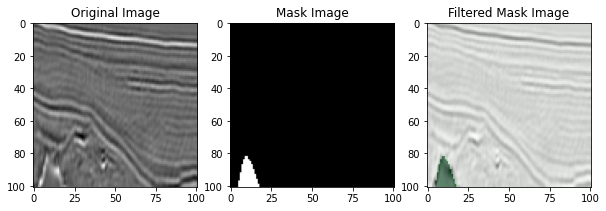

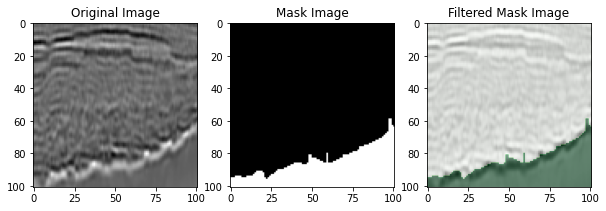

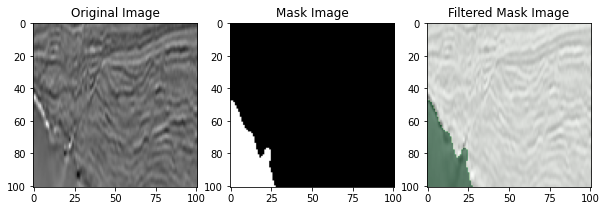

In [ ]:
random_names = ['6caec01e67','2bfa664017','1544a0e952']

images = [Image.open(os.path.join(image_path, name+'.png')) for name in random_names]
masks = [Image.open(os.path.join(mask_path, name+'.png')) for name in random_names]

# Compose, composes several transforms together, for this case Grayscale and ToTensor
# Grayscale is used to convert an image to grayscale image
# ToTensor is used to convert an PIL image or ndarray to Tensor
transforms = T.Compose([T.Grayscale(), T.ToTensor()])
# to perform transformation for single image, transform(images[0]).shape, and it will return an tensor of size (1, 101, 101)
# stack - to concatenate tensors
# for all images
x = torch.stack([transforms(image) for image in images])
# the shape of x will be (number of images(3), 1, 101, 101)
y = torch.stack([transforms(mask) for mask in masks])


for i in range(len(random_names)):
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.imshow(images[i])
  plt.title('Original Image')

  plt.subplot(132)
  plt.imshow(masks[i])
  plt.title('Mask Image')

  plt.subplot(133)
  plt.imshow(x[i].squeeze(), cmap="Greys")
  plt.imshow(y[i].squeeze(), alpha=0.5, cmap="Greens") 
  plt.title('Filtered Mask Image')
  plt.show()

**In the above "Mask Images" white area is used to represnent the salt. Black and blue area is not salt.**

In [ ]:
# custom Dataset creation
# our custom class should inherit the torch.utils.data.Dataset and override __getitem__ and __len__

class segmentDataset(Dataset):
  # map style dataset creation, doesn't need iter
  def __init__(self, image_path, mask_path):
    # initializing paths for images and masks
    self.image_path = image_path
    self.mask_path = mask_path
        
    # creating a list of all the images with full path
    image_list= glob.glob(image_path +'/*.png')
    # grabbing just the name of a file from the full image path and appending them to sample_names
    sample_names = []
    for file in image_list:
      sample_names.append(file.split('/')[-1].split('.')[0])
            
    # initializing file names
    self.sample_names = sample_names
        
    # initializing the above mentioned transform operation
    self.transforms = T.Compose([T.Grayscale(), T.ToTensor()])
            
  def __getitem__(self, idx):
    # to support the indexing such that dataset[i] can be used to get ith sample
    image = Image.open(os.path.join(self.image_path, self.sample_names[idx]+'.png') )
    mask = Image.open(os.path.join(self.mask_path, self.sample_names[idx]+'.png') )
    return self.transforms(image), self.transforms(mask)

  def __len__(self):
    # returns the size of the dataset
    return len(self.sample_names)

In [ ]:
train_dataset = segmentDataset(image_path, mask_path)

### Creating U-net Architecture

In [ ]:
class convBlock(nn.Module):
  def __init__(self, in_channels, filters, size, stride = 1, activation = True):
    super(convBlock, self).__init__()
    # initializing variables
    self.activation = activation
    # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.conv = nn.Conv2d(in_channels, filters, size, stride = stride, padding = size//2)
    # nn.BatchNorm2d(num_features)
    self.norm = nn.BatchNorm2d(filters)

  def forward(self, x):
    x = self.conv(x)
    x = self.norm(x)
    if self.activation:
      # nn.functional.relu(input)
      return F.relu(x)
    else:
      return x

class residualBlock(nn.Module):
  def __init__(self, in_channels, filters, size = 3):
    super(residualBlock, self).__init__()
    # initializing variables
    # # nn.BatchNorm2d(num_features)
    self.norm = nn.BatchNorm2d(in_channels)
    self.conv1 = convBlock(in_channels, filters, size)
    self.conv2 = convBlock(filters, filters, size, activation=False)

  def forward(self, x):
    residual = x  
    # nn.functional.relu(input)
    x = F.relu(x)
    x = self.norm(x)
    x = self.conv1(x)
    x = self.conv2(x)
    return x 

class deconvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size = 2, stride = 2):
    super(deconvBlock, self).__init__()
    # initializing variables
    # nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride)
    self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)

  def forward(self, x1, x2):
    xd = self.deconv(x1)
    # cat is used to concatenate sequence of tensors, dim=0 means row-wise and dim=1 means column-wise
    x = torch.cat([xd, x2], dim = 1)
    return x

In [ ]:
class UnetModel(nn.Module):
    def __init__(self, filters = 16, dropout = 0.5):
        super(UnetModel, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, filters, 3, padding = 1),
            residualBlock(filters, filters),
            residualBlock(filters, filters),
            nn.ReLU()
        )
        
        self.conv2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout/2),
            nn.Conv2d(filters, filters * 2, 3, padding = 1),
            residualBlock(filters * 2, filters * 2),
            residualBlock(filters * 2, filters * 2),
            nn.ReLU()
        )
        
        self.conv3 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 2, filters * 4, 3, padding = 1),
            residualBlock(filters * 4, filters * 4),
            residualBlock(filters * 4, filters * 4),
            nn.ReLU()
        )
        
        self.conv4 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 4, filters * 8, 3, padding = 1),
            residualBlock(filters * 8, filters * 8),
            residualBlock(filters * 8, filters * 8),
            nn.ReLU()
        )
            

        self.middle = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 8, filters * 16, 3, padding = 3//2),
            residualBlock(filters * 16, filters * 16),
            residualBlock(filters * 16, filters * 16),
            nn.ReLU()
        )
        
        self.deconv4 = deconvBlock(filters * 16, filters * 8, 2)
        self.upconv4 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 16, filters * 8, 3, padding = 1),
            residualBlock(filters * 8, filters * 8),
            residualBlock(filters * 8, filters * 8),
            nn.ReLU()
        )
  

        self.deconv3 = deconvBlock(filters * 8, filters * 4, 3)
        self.upconv3 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 8, filters * 4, 3, padding = 1),
            residualBlock(filters * 4, filters * 4),
            residualBlock(filters * 4, filters * 4),
            nn.ReLU()
        )
        
        self.deconv2 = deconvBlock(filters * 4, filters * 2, 2)
        self.upconv2 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 4, filters * 2, 3, padding = 1),
            residualBlock(filters * 2, filters * 2),
            residualBlock(filters * 2, filters * 2),
            nn.ReLU()
        )

        self.deconv1 = deconvBlock(filters * 2, filters, 3)
        self.upconv1 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 2, filters, 3, padding = 1),
            residualBlock(filters, filters),
            residualBlock(filters, filters),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Conv2d(filters, 1, 3, padding = 1)
        )
        
    def forward(self, x):
        conv1 = self.conv1(x) 
        # 101 -> 50
        conv2 = self.conv2(conv1) 
        # 50 -> 25
        conv3 = self.conv3(conv2) 
        # 25 -> 12
        conv4 = self.conv4(conv3) 
        # 12 - 6
        x = self.middle(conv4) 
        
        # 6 -> 12
        x = self.deconv4(x, conv4)
        x = self.upconv4(x)
        # 12 -> 25
        x = self.deconv3(x, conv3)
        x = self.upconv3(x)
        # 25 -> 50
        x = self.deconv2(x, conv2)
        x = self.upconv2(x)
        # 50 -> 101
        x = self.deconv1(x, conv1)
        x = self.upconv1(x)

        return x

In [ ]:
def get_iou_score(outputs, labels):
    '''
    This function is used to get IOU score is in between A and B. IOU is also known as jaccard similarity.
    Inputs : outputs(array), labels(array)
    Output : IOU score
    '''

    # squeeze basically removes axes of length 1 from array
    A = labels.squeeze().bool()
    # where is used to return a tensor of elements selected from either a and b based on condition
    # torch.where(condition, a, b)
    # if condition is true then a else b
    # torch.zeros_like return a tensor of size same as outputs and torch.ones_like return a tensor of size as outputs
    pred = torch.where(outputs<0., torch.zeros_like(outputs), torch.ones_like(outputs))
    B = pred.squeeze().bool()
    # performing IOU
    intersection = (A & B).float().sum((1,2))
    union = (A | B).float().sum((1, 2)) 
    iou = (intersection + 1e-6) / (union + 1e-6)  
    return iou

In [ ]:
def train_one_batch(model, x, y):
    '''
    This function is used to train a single batch only.
    Inputs : model(unet model for this case), x(data point), y(label)
    Output : loss and IOU
    '''
    # to is used to move a torch tensor to device memory, either CPU or CUDA. CUDA for this case
    x, y = x.to(device), y.to(device)

    # passing input x to the unet model, and taking it's output
    outputs = model(x)
    # applying loss function on the models output and the actual output(label)
    loss = loss_fn(outputs, y)
    # getting IOU score
    iou = get_iou_score(outputs, y).mean()
    
    # MANDATORY : to set gradients of the parameters in the model to 0, before starting the backpropagation(PyTorch policy)
    # because of this we can zero out our gradients, so that we can do parameter updates correctly
    # if we didn't perform it then gradients may point in some other direction as compare to intended direction
    # alternate model.zero_grad(), same working
    optimizer.zero_grad()
    # MANDATORY : loss.backward() is computing the gradient of loss w.r.t. all the parameters, and store them to parameter.grad
    # attribute of each parameter
    loss.backward()
    # MANDATORY : optimizer.step() is updating all the parameters based on parameter.grad
    optimizer.step()
    # item() is used to get a number form a tensor containing single value
    return loss.item(), iou.item()

In [ ]:
def timeSince(since):
    '''
    This function is used to represent the training time for each step by adding time of the previous steps.
    Input : since (previous time)
    return : current time in (min sec)
    '''
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
NUM_EPOCHS = 300
BATCH_SIZE = 32

# instantiating UnetModel using CUDA
model = UnetModel().to(device)
# model.train is just used to specify that we are doing training, so that the layers like dropout which works differently
# in train time and test time, works accordingly
model.train()

# calling torch's Adam optimizer with default settings
optimizer = torch.optim.Adam(model.parameters())
# this loss combines a Sigmoid layer and the BCELoss in one single class.
loss_fn = nn.BCEWithLogitsLoss()
# adjusting learning rate
# max mode indicate lr will reduce when quantity monitored has stopped increasing
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

# loading data from train_dataset, drop_last means dropping last incomplete batch
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
steps  = train_dataset.__len__() // BATCH_SIZE
print(steps,"steps per epoch")

start = time.time()
train_losses = []
train_ious = []
# iterations
for epoch in range(1, NUM_EPOCHS + 1):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, NUM_EPOCHS))
    running_iou = []
    running_loss = []
    # loading dataloader
    for step, (x, y) in enumerate(train_dataloader):
        # training by batch by batch
        loss, iou = train_one_batch(model, x, y)
        running_iou.append(iou)
        running_loss.append(loss)
        print('\r{:6.1f} %\tloss {:8.4f}\tIoU {:8.4f}'.format(100*(step+1)/steps, loss, iou), end = "") 
        
    print('\r{:6.1f} %\tloss {:8.4f}\tIoU {:8.4f}\t{}'.format(100*(step+1)/steps,np.mean(running_loss),np.mean(running_iou), timeSince(start)))
    # checking for the scheduler
    scheduler.step(np.mean(running_iou))
    
    train_losses.append(loss)
    train_ious.append(iou)

125 steps per epoch
----------
Epoch 1/300
 100.0 %	loss   0.4264	IoU   0.4221	0m 24s
----------
Epoch 2/300
 100.0 %	loss   0.3219	IoU   0.5491	0m 48s
----------
Epoch 3/300
 100.0 %	loss   0.2794	IoU   0.5738	1m 12s
----------
Epoch 4/300
 100.0 %	loss   0.2708	IoU   0.5893	1m 37s
----------
Epoch 5/300
 100.0 %	loss   0.2484	IoU   0.6054	2m 2s
----------
Epoch 6/300
 100.0 %	loss   0.2385	IoU   0.6225	2m 27s
----------
Epoch 7/300
 100.0 %	loss   0.2290	IoU   0.6310	2m 52s
----------
Epoch 8/300
 100.0 %	loss   0.2300	IoU   0.6366	3m 17s
----------
Epoch 9/300
 100.0 %	loss   0.2210	IoU   0.6467	3m 42s
----------
Epoch 10/300
 100.0 %	loss   0.2255	IoU   0.6313	4m 7s
----------
Epoch 11/300
 100.0 %	loss   0.2138	IoU   0.6589	4m 32s
----------
Epoch 12/300
 100.0 %	loss   0.2109	IoU   0.6710	4m 57s
----------
Epoch 13/300
 100.0 %	loss   0.1909	IoU   0.6896	5m 22s
----------
Epoch 14/300
 100.0 %	loss   0.1933	IoU   0.6871	5m 47s
----------
Epoch 15/300
 100.0 %	loss   0.1891	IoU   

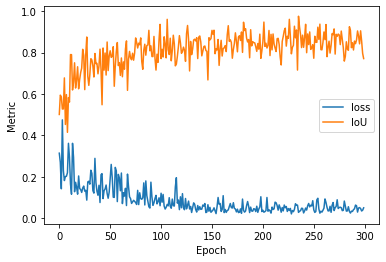

In [ ]:
# Plotting IoU vs. Loss

plt.plot(train_losses, label = 'loss')
plt.plot(train_ious, label = 'IoU')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [ ]:
# model to save/load path
model_path = '/content/drive/MyDrive/Kaggle_Salt_Identification/unet_model_final.pth'

In [ ]:
## save weights  
# state_dict() - python dictionary which maps each layes to it's parameter tensors  
torch.save(model.cpu().state_dict(), model_path)

## load model
# model = torch.load(model_path)

In [ ]:
# declaring we are performing evaluation, so dropout will behave accordingly
model.eval()

UnetModel(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): residualBlock(
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): convBlock(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2): convBlock(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): residualBlock(
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): convBlock(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2):

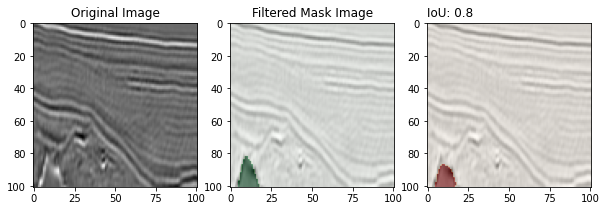

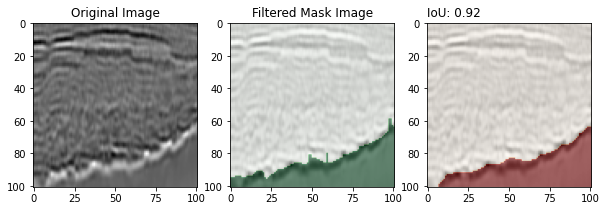

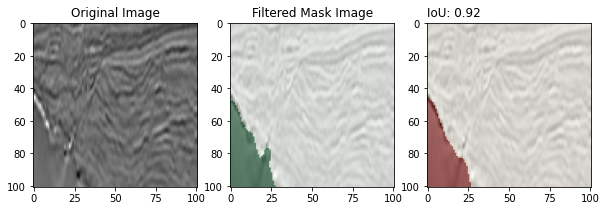

In [ ]:
# for few sample selected images checking the predictions

names = ['6caec01e67','2bfa664017','1544a0e952']
images = [Image.open(os.path.join(image_path, name+'.png')) for name in names]
masks = [Image.open(os.path.join(mask_path, name+'.png')) for name in names]

transforms = T.Compose([T.Grayscale(), T.ToTensor()])
x = torch.stack([transforms(image) for image in images])
y = torch.stack([transforms(mask) for mask in masks])

# calling model and passing input x to get output
outputs = model(x)
# getting predictions
# where is used to return a tensor selected from either a and b based on condition
preds = torch.where(outputs<0., torch.zeros_like(outputs), torch.ones_like(outputs))
# getting IoU score
ious = get_iou_score(outputs, y)

for i in range(len(names)):
  plt.figure(figsize=(10,6))

  # subplot 1
  plt.subplot(131)
  plt.imshow(images[i])
  plt.title('Original Image')

  # subplot 2
  plt.subplot(132)
  plt.imshow(x[i].squeeze(), cmap="Greys")
  plt.imshow(y[i].squeeze(), alpha=0.5, cmap="Greens")
  plt.title('Filtered Mask Image')

  # subplot 3
  plt.subplot(133)
  plt.imshow(x[i].squeeze(), cmap="Greys")
  plt.imshow(preds[i].squeeze(), alpha=0.5, cmap="OrRd")
  plt.title("IoU: " + str(round(ious[i].item(), 2)), loc = 'left')

  plt.show()

In [ ]:
# iter is used to return a stream of data from dataloader
trainiter = iter(train_dataloader)
# calling for next stream and getting images and masks
images, masks = next(trainiter)

# for images predicting output from model
outputs = model(images)
# getting predictions
preds = torch.where(outputs<0., torch.zeros_like(outputs), torch.ones_like(outputs))
# getting IoU score
ious = get_iou_score(outputs, masks).numpy()

In [ ]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
image_path = "/content/competition_data/test/images"
sub_df = pd.read_csv('/content/competition_data/sample_submission.csv')
transforms = T.Compose([T.Grayscale(), T.ToTensor()])
n = sub_df.shape[0]

rle_mask = []
for idx in range(n):
    ## load image
    sample_name = sub_df['id'][idx]
    image = Image.open(os.path.join(image_path, sample_name+'.png') )
    image = transforms(image)
    ## predict
    out = model(image.unsqueeze(0)).squeeze()
    pred = torch.where(out<0., torch.zeros_like(out), torch.ones_like(out))
    ## write mask
    rle_mask.append(rle_encode(pred.numpy()))
    print("\rprogress {}/{}".format(idx+1, n), end = "")
    
sub_df['rle_mask'] = rle_mask

progress 18000/18000

In [ ]:
sub_df.head(10)

,id,rle_mask
0,3e06571ef3,60 42 161 42 263 41 366 39 468 38 571 36 675 3...
1,a51b08d882,42 60 143 60 244 60 347 58 449 57 551 56 653 5...
2,c32590b06f,1 707 709 100 810 915 1727 698 2426 100 2527 2...
3,15f7a047c7,1 15 102 16 123 3 203 26 304 25 405 25 506 25 ...
4,e8827bc832,
5,d83fe9fa7a,
6,2de62031ee,
7,29cf979b92,32 61 133 61 235 60 336 57 437 55 538 53 640 5...
8,58ef954a94,10 92 110 93 211 93 312 93 414 92 515 92 617 9...
9,ccec631d75,50 52 151 52 251 53 353 52 454 52 555 52 657 5...


In [ ]:
sub_df.to_csv('/content/drive/MyDrive/Kaggle_Salt_Identification/submission.csv', index=False)